In [4]:
%run /home/cz136/project/sa/lib/header.ipynb
phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
e_list=np.load("/home/cz136/project/sa/data/e_array.npy")

In [3]:
print(len(clusters))
print(len(shapes))

7001
394334


In [3]:
def drop_poor_centers():
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/missing_centers.npy",center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 3


In [4]:
print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes[('All','PP')]<=0.55))

17512
17512
138875


In [5]:
shapes=shapes[shapes[('All','PP')]>=0.55]
shapes=shapes[shapes[('All','e1')]!=-9999]
shapes=shapes[shapes[('All','e2')]!=-9999]

# clusters[('Alt', 'Alt1', 'P_CEN')]<=0.55
# clusters.drop([202],inplace=True)

print(len(clusters))
print(len(shapes))

7001
244926


# Get phi 

In [7]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [8]:
def get_theta_for_obj(obj1,obj2):
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [9]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(e2,e1)*180/np.pi
    return(α)

In [10]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        phi=pa-theta
    #     print(center.index)
        return(phi)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]))

In [10]:
phi_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])
    phi_list.append(phi_array)
phi_list=np.array(phi_list)

In [11]:
phi_1d=np.concatenate(phi_list)

phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

phi_1d=np.sort(phi_1d)

In [12]:
np.save("/home/cz136/project/sa/data/phi_1d",phi_1d)

In [13]:
phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print(" {} {} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

 44.844592532837375 0.05562359604641191 


count    216924.000000
mean         44.844593
std          25.906806
min           0.000274
25%          22.500000
50%          44.773795
75%          67.500000
max          89.999723
dtype: float64

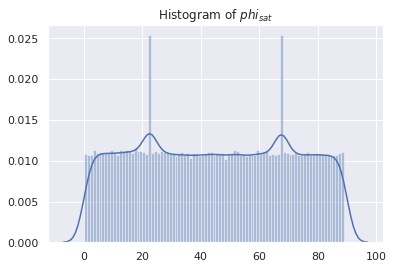

In [28]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $phi_{sat}$") 
pd.Series(phi_1d).describe()

In [15]:
phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[22 67 17  3 59 14  9 51 12 13 19 52 15 26 18 24 62 33 28  7 61 68 43 88
 42 27 76 20  5 45 87 79 25 16 38 69 47  4 46 35 23 72  8  6 37 10 29 64
 82 78 41  0 50 83 66 71 81 30 60 80 70 21 32 75 49 54 40 58 85 57 56 86
 34 73 74 11  1 65 77  2 53 63 44 31 55 39 84 36 48]
[5447 5444 2471 2435 2431 2426 2423 2417 2415 2404 2404 2404 2400 2399
 2399 2396 2395 2388 2385 2383 2380 2376 2376 2373 2370 2367 2366 2365
 2363 2361 2361 2360 2359 2357 2356 2356 2355 2355 2352 2351 2350 2348
 2347 2343 2340 2340 2334 2334 2334 2334 2331 2328 2327 2326 2325 2324
 2323 2321 2321 2319 2316 2316 2315 2314 2313 2310 2309 2307 2305 2303
 2300 2298 2298 2298 2297 2297 2295 2293 2292 2289 2288 2287 2286 2282
 2268 2262 2260 2229 2192]


count    5447.000000
mean       22.499381
std         0.188050
min        22.000249
25%        22.500000
50%        22.500000
75%        22.500000
max        22.999386
dtype: float64

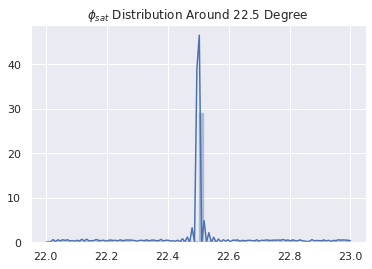

In [16]:
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 Degree")
pd.Series(first_cluster).describe()

count    5447.000000
mean       67.496220
std         0.188900
min        67.000313
25%        67.500000
50%        67.500000
75%        67.500000
max        68.000689
dtype: float64

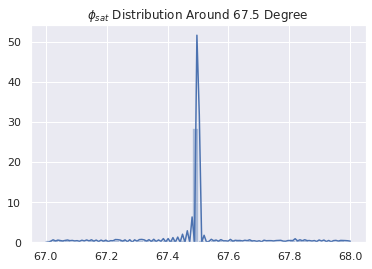

In [17]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 Degree")
pd.Series(second_cluster).describe()

# Get e

In [18]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    244926.000000
mean          0.000053
std           0.148712
min          -0.988648
25%          -0.079860
50%          -0.000149
75%           0.079905
max           0.977076
Name: (All, e1), dtype: float64

In [19]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    244926.000000
mean         -0.000403
std           0.149548
min          -0.845018
25%          -0.081402
50%          -0.000395
75%           0.080491
max           0.902807
Name: (All, e2), dtype: float64

In [20]:
np.histogram(e1,bins=np.arange(-10000,10000,1))

(array([0, 0, 0, ..., 0, 0, 0]),
 array([-10000,  -9999,  -9998, ...,   9997,   9998,   9999]))

In [11]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [12]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [23]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [24]:
np.save("/home/cz136/project/sa/data/e_array",e_list)

In [5]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=1.626472e-04, std_mean=3.199814e-04


count    216924.000000
mean          0.000163
std           0.149032
min          -0.994047
25%          -0.081263
50%           0.000392
75%           0.081108
max           0.818467
dtype: float64

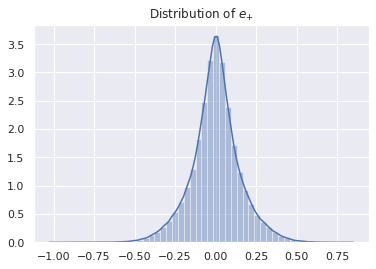

In [17]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=1.211951e-03, std_mean=3.194525e-04


count    216924.000000
mean          0.001212
std           0.148786
min          -0.908880
25%          -0.078595
50%           0.003332
75%           0.081035
max           0.939512
dtype: float64

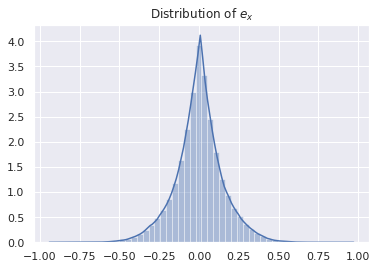

In [19]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()

# Analysis

It seems the only things unexpected are the features around 22.5 and 67.5 degrees and the non-zero mean of ex.